In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('svg')

# Decoding analyses

We first aggregate and plot mean-average-rank statistics for each decoder.

In [3]:
models = {
#     "GloVe": "baseline",
#     "ConvS2S": "fairseq.wmt14.en-fr.fconv",
#     "InferSent": "infersent.allnli",
#     "IMDB": "imdbsentiment",
#     "skipthought": "skipthought",
#     "DisSent": "dissent.books8.epoch9",
#     "order": "order-embeddings",
#     "ELMo": "elmo.2x4096",
    "BERT": "bert.base",
#     "BERT Large": "bert.base-large",
    "BERT-MRPC": "bert.base.finetune-MRPC",
    "BERT-CoLA": "bert.base.finetune-CoLA",
    "BERT-MNLI": "bert.base.finetune-MNLI",
    "BERT-RTE": "bert.base.finetune-RTE",
    "BERT-SST": "bert.base.finetune-SST",
    "BERT-WNLI": "bert.base.finetune-WNLI",
    "BERT-QQP": "bert.base.finetune-QQP",
#     "openai": "transformer.roc",
}

In [4]:
def analyze_encoding(name, results_path):
    df = pd.read_csv(results_path, index_col=[0, 1])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.violinplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
    plt.ylim((40, 260))
    plt.ylabel("average rank")
    plt.title("%s: Within-subject MAR" % name)
    
    subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(level=0, drop=True).mean(axis=1)).T
    subj_perf.plot.bar(title="%s: Within-subject MAR" % name)
    
    return subj_perf

In [5]:
stats = {}

--------

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


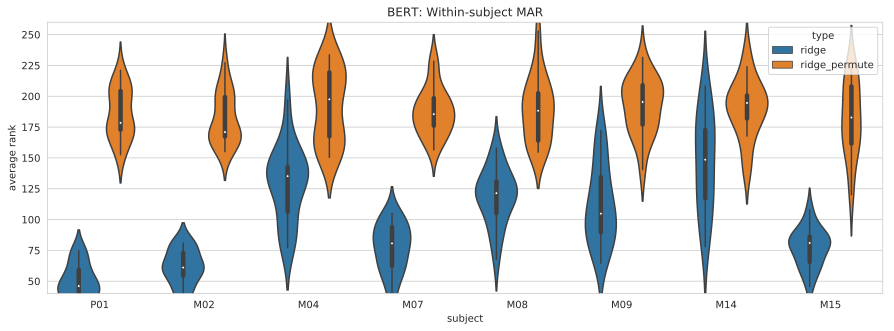

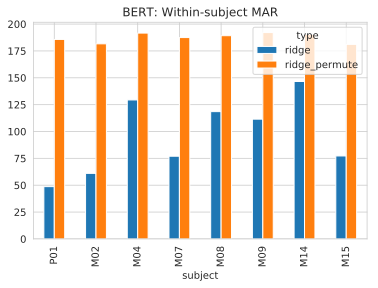

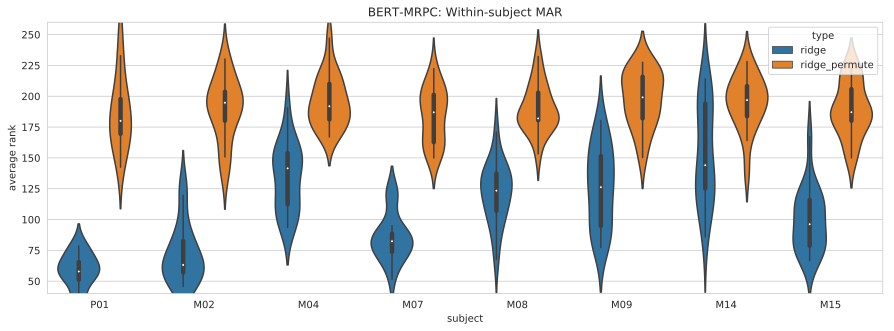

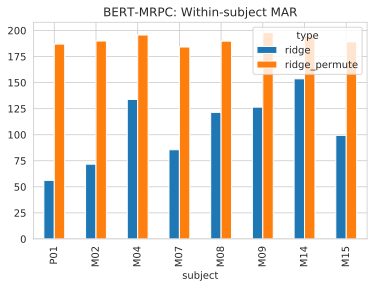

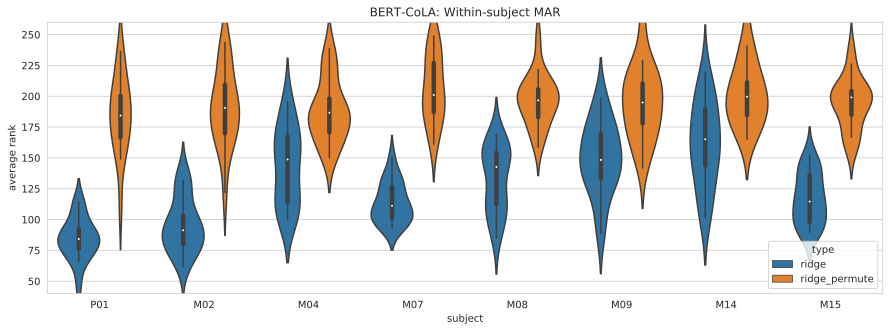

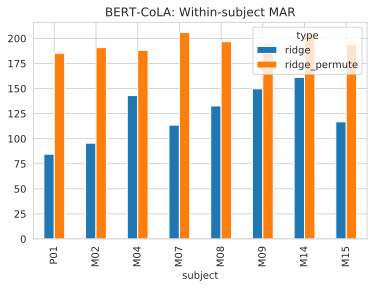

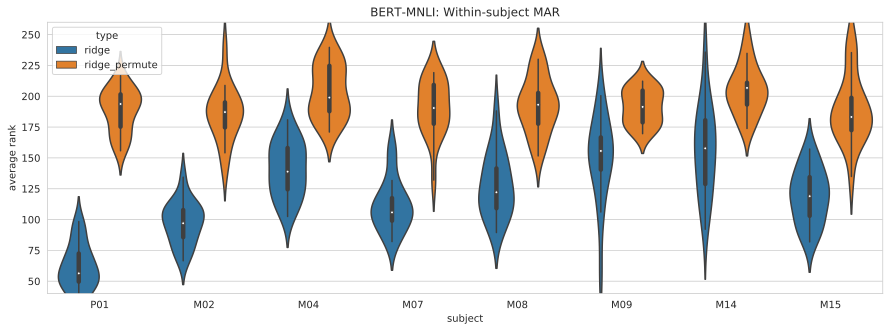

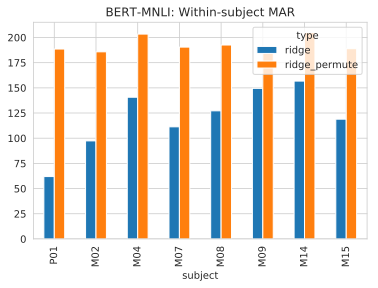

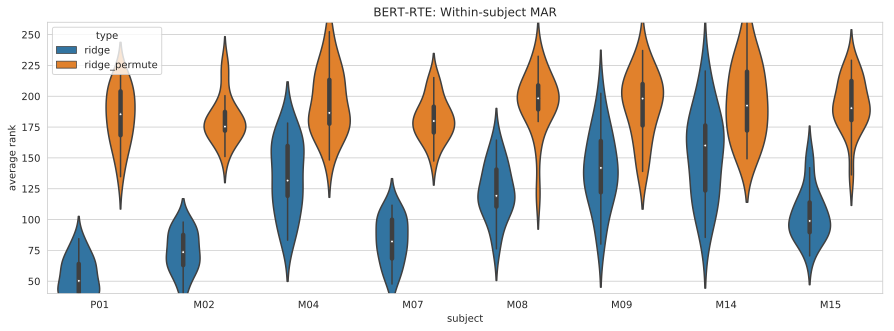

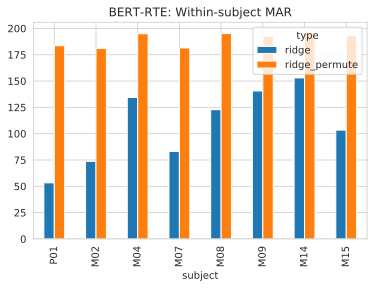

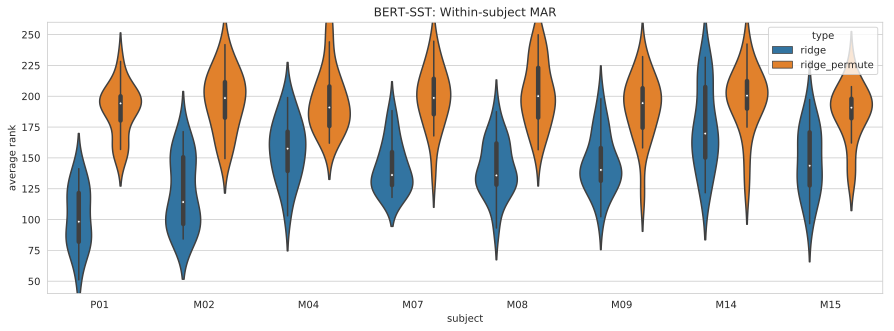

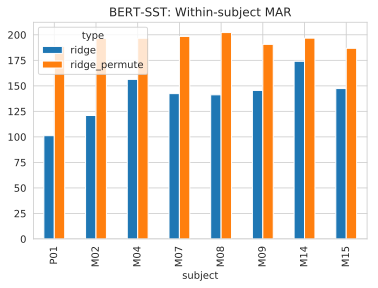

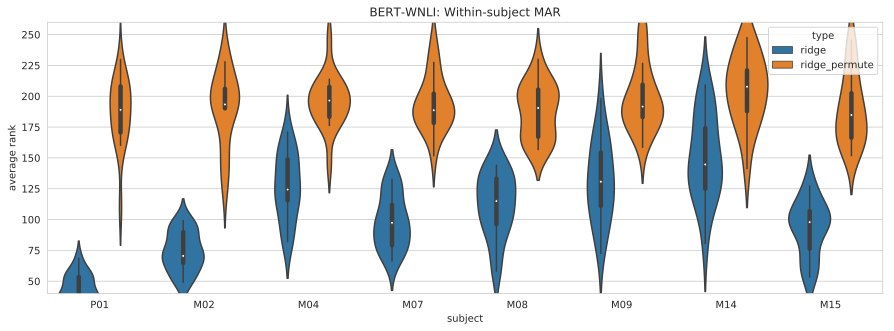

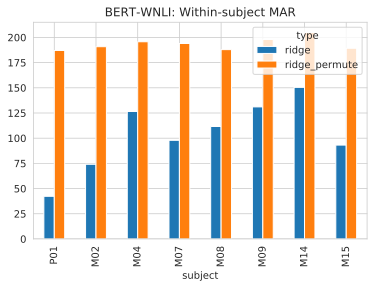

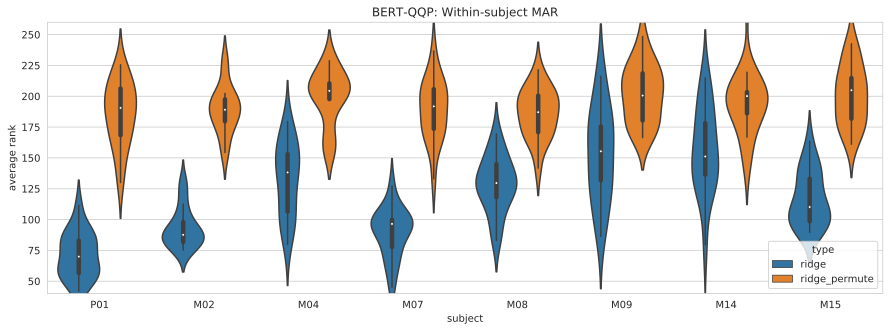

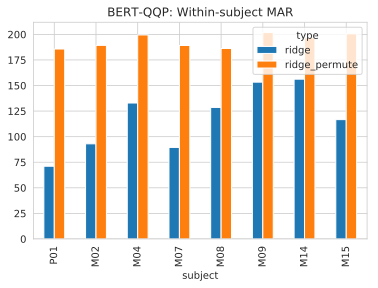

In [6]:
for model, path in models.items():
    try:
        stats[model] = analyze_encoding(model, "perf.384sentences.%s.csv" % path)
    except: pass

-----

# Pairwise statistical tests

We'll calculate which model pair differences in performance are significant by the Wilcoxon test on the original sentence-rank data. (The data graphed above are all computed from MAR statistics (meaned across sentences).)

In [7]:
# Aggregate statistics.
f = pd.concat(stats, names=["target", "subject"]).reset_index()

In [8]:
f.head()

type,target,subject,ridge,ridge_permute
0,BERT,P01,48.703704,185.690476
1,BERT,M02,61.005291,181.613757
2,BERT,M04,129.359788,191.584656
3,BERT,M07,76.989418,187.447090
4,BERT,M08,118.492063,189.187831


In [9]:
# Load full model predictions.
model_preds = {model: pd.read_csv("perf.384sentences.%s.pred.csv" % model_path).sort_index() for model, model_path in models.items()}

In [10]:
from scipy.stats import wilcoxon
import itertools

wilcoxon_results = []
for (model1_name, model1), (model2_name, model2) in itertools.combinations(model_preds.items(), 2):
    w_stat, p_val = wilcoxon(model1["rank"], model2["rank"])
    wilcoxon_results.append((model1_name, model2_name, w_stat, p_val))
    
wilcoxon_results = pd.DataFrame(wilcoxon_results, columns=["model1", "model2", "w_stat", "p_val"]).set_index(["model1", "model2"])
# Bonferroni correction
correction = len(list(itertools.combinations(model_preds.items(), 2)))
wilcoxon_results["significant_bonferroni"] = wilcoxon_results["p_val"] < 0.01 / correction

In [11]:
wilcoxon_results.sort_values("p_val")

w_stat          p_val  significant_bonferroni
model1    model2                                                     
BERT      BERT-SST   1204625.5  2.274967e-105                    True
          BERT-CoLA  1331261.5   7.988658e-82                    True
BERT-SST  BERT-WNLI  1417192.5   1.062295e-67                    True
BERT-MRPC BERT-SST   1484652.5   2.563663e-58                    True
BERT-RTE  BERT-SST   1488559.5   5.875551e-55                    True
BERT      BERT-QQP   1499558.5   4.688888e-53                    True
          BERT-MNLI  1513606.5   1.041537e-51                    True
BERT-CoLA BERT-WNLI  1583426.5   7.777833e-43                    True
BERT      BERT-RTE   1645976.0   3.239402e-31                    True
BERT-MNLI BERT-WNLI  1705832.5   4.100993e-29                    True
BERT-CoLA BERT-RTE   1711715.5   3.977957e-28                    True
BERT-MRPC BERT-CoLA  1730858.5   1.931316e-27                    True
BERT-WNLI BERT-QQP   1745096.5   2.003495e-25                    True
BERT-SST  BERT-QQP   1770827.5   1.065054e-23                    True
BERT-MNLI BERT-SST   1830274.0   1.626053e-18                    True
BERT-MRPC BERT-MNLI  1823380.5   4.990586e-18                    True
BERT-MNLI BERT-RTE   1843007.5   1.762442e-16                    True
BERT-MRPC BERT-QQP   1881256.0   4.790888e-14                    True
BERT-CoLA BERT-SST   1925172.0   6.784954e-12                    True
BERT      BERT-MRPC  1877144.5   9.792560e-12                    True
BERT-RTE  BERT-QQP   1926715.0   2.633205e-10                    True
BERT      BERT-WNLI  1930421.0   9.023952e-10                    True
BERT-RTE  BERT-WNLI  2004618.0   3.622555e-05                    True
BERT-CoLA BERT-QQP   2040215.0   1.065083e-04                    True
BERT-MRPC BERT-RTE   2085490.0   2.926310e-02                   False
BERT-CoLA BERT-MNLI  2143701.5   3.041313e-02                   False
BERT-MRPC BERT-WNLI  2163772.0   8.167914e-02                   False
BERT-MNLI BERT-QQP   2165619.5   1.372729e-01                   False

---------

# Aggregate graphs

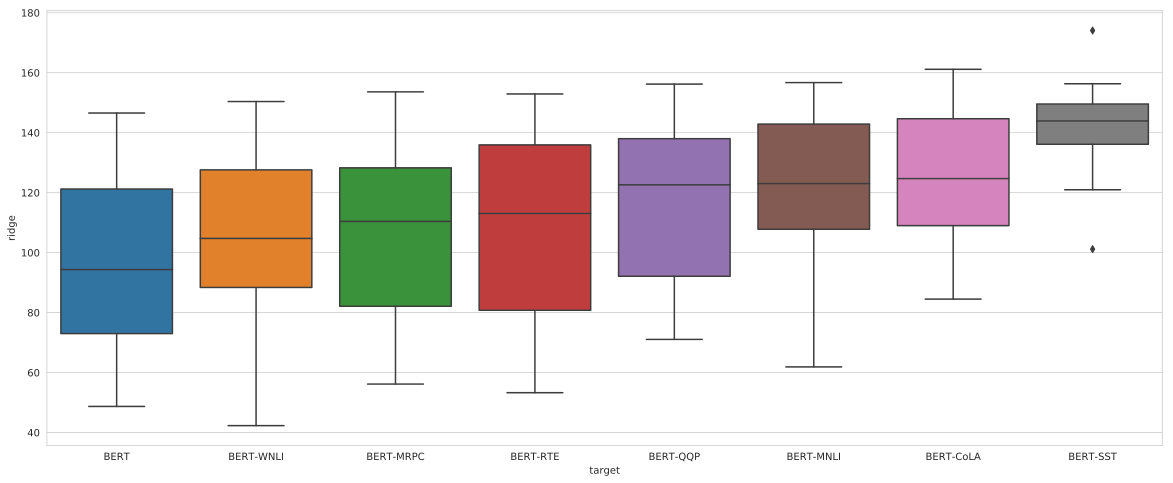

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))

target_order = f.groupby("target").ridge.agg("mean").argsort()
sns.boxplot(x="target", y="ridge", data=f, ax=ax, order=target_order.index[target_order])

In [13]:
f.groupby("target").ridge.agg("mean")

target
BERT          96.226190
BERT-CoLA    124.590608
BERT-MNLI    120.428241
BERT-MRPC    106.018188
BERT-QQP     117.650132
BERT-RTE     108.014550
BERT-SST     141.115079
BERT-WNLI    103.360450
Name: ridge, dtype: float64

[-0.4  0.6  1.6  2.6  3.6  4.6  5.6  6.6  0. ]


/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.87, -0.025, '* = p<0.01 for Bonferroni-corrected Wilcoxon test')

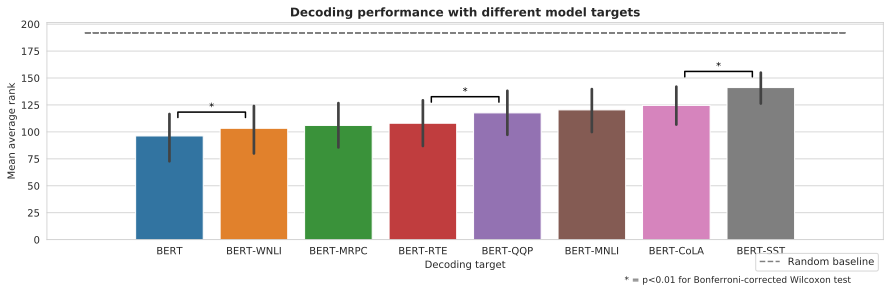

In [14]:
fig, ax = plt.subplots(figsize=(15,4))
sns.barplot(x="target", y="ridge", order=target_order.index[target_order], data=f)
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance with different model targets", weight="bold")

# Plot baseline
import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(np.repeat(384 / 2, len(target_order)), -1, len(target_order), colors="gray", linestyles="dashed", label="Random baseline")

# Plot legend
plt.legend(loc='upper right', bbox_to_anchor=(1, -0.04))

# Plot significant differences
xticks = list(zip(*plt.xticks()))
mean_results = f.groupby("target").ridge.agg("mean")
for (m1_pos, m1_label), (m2_pos, m2_label) in zip(xticks, xticks[1:]):
    m1_label = m1_label.get_text()
    m2_label = m2_label.get_text()
    try:
        significant = wilcoxon_results.loc[m1_label, m2_label].significant_bonferroni
    except:
        significant = wilcoxon_results.loc[m2_label, m1_label].significant_bonferroni
    
    if significant:
        y = max(mean_results[m1_label], mean_results[m2_label]) + 10
        h = 5
        col = 'k'
        plt.plot([m1_pos + 0.1, m1_pos + 0.1, m2_pos - 0.1, m2_pos - 0.1], [y, y + h, y + h, y], lw=1.5, c=col)
        plt.text((m1_pos+m2_pos)*.5, y + h, "*", ha='center', va='bottom', color=col)
        
plt.figtext(0.87, -0.025, "* = p<0.01 for Bonferroni-corrected Wilcoxon test", wrap=True, horizontalalignment='right', fontsize=9)

/home/jgauthie/.conda/envs/tf1.12.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Decoding performance between subjects')

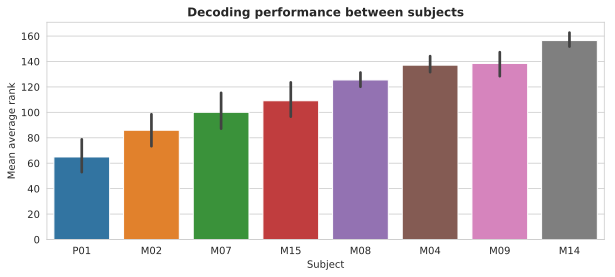

In [15]:
order = f.groupby("subject").ridge.agg("mean").argsort()
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x="subject", y="ridge", order=order.index[order], data=f, ax=ax)
plt.xlabel("Subject")
plt.ylabel("Mean average rank")
plt.title("Decoding performance between subjects", weight="bold")